# Titanic survival prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randrange

In [2]:
import sklearn.preprocessing
import sklearn.svm

In [3]:
from sklearn.model_selection import train_test_split

## Understanding data

In [5]:
train = pd.read_csv("train.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


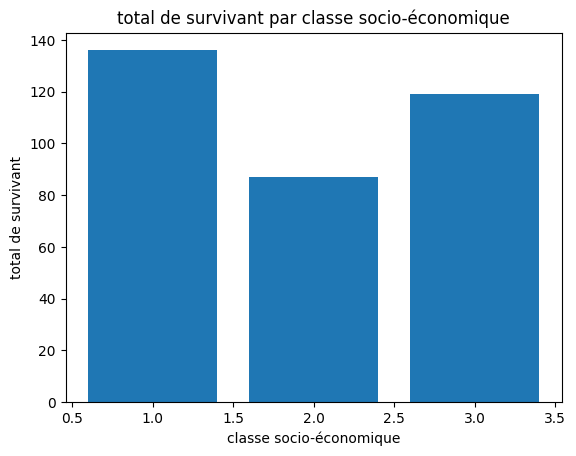

In [30]:
somme_survived_per_class = train.groupby(['Pclass'], as_index=False)['Survived'].agg({"sum"})
plt.bar(somme_survived_per_class['Pclass'], somme_survived_per_class['sum'])
plt.title('total de survivant par classe socio-économique')
plt.xlabel('classe socio-économique')
plt.ylabel('total de survivant')
plt.show()

## Pre-processing

In [ ]:
Y = train['Survived']
train = train.drop('Survived', axis=1)

#Entrainement du modèle de One Hot Encoder
onehot = sklearn.preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
Xnum = train.select_dtypes(exclude='object').drop('Pclass', axis=1)
Xcat = train.select_dtypes(include='object')\
            .join(train['Pclass'])\
            .drop(['Embarked', 'Name', 'Ticket'], axis=1)
onehot.fit(Xcat)

In [ ]:
def clean(df : pd.DataFrame, encoder: sklearn.preprocessing.OneHotEncoder):
    """
    Une fonction pour préparer les données au modèle de prédiction.
    Parameters:
    df : le dataframe
    encoder : le modèle qui encodera le dataframe en OneHotVector
    """
    without_NaN = df.dropna()

    #je récupère les cabines
    tmp = list(set(without_NaN['Cabin'].to_list()))

    #j'attribue aléatoirement des cabines 
    df["Cabin"] = df["Cabin"].apply(lambda cabin : (tmp[randrange(len(tmp))] if pd.isna(cabin) else cabin))

    #j'ai jugé que la column embarked n'avait pas d'importance, pareil pour id et le nom
    df = df.drop("Embarked", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Ticket", axis=1)
    df = df.drop("PassengerId", axis=1)

    #interpolate les autres valeurs NaN
    df = df.interpolate(method='pad')

    #je normalize les valeurs numeriques
    df["Age"] = df["Age"]/df["Age"].max()
    df["Fare"] = df["Fare"]/df["Fare"].max()

    #j'encode en OneHotVector
    df_num = df.select_dtypes(exclude='object').drop('Pclass', axis=1)
    df_cat = df.select_dtypes(include='object').join(df['Pclass'])

    cat_columns = [f"{col}_{cat}" for i, col in enumerate(df_cat.columns) for cat in encoder.categories_[i]]

    onehot_features = pd.DataFrame(encoder.transform(df_cat), columns=cat_columns)

    df = df_num.join(onehot_features)

    return df


In [ ]:
#Nettoyage des données
X = clean(train, onehot)

#splitting into training set and validation set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=0)


In [ ]:
train = pd.read_csv("train.csv")

Y = train['Survived']
train = train.drop('Survived', axis=1)

#Entrainement du modèle de One Hot Encoder
onehot = sklearn.preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
Xnum = train.select_dtypes(exclude='object').drop('Pclass', axis=1)
Xcat = train.select_dtypes(include='object')\
            .join(train['Pclass'])\
            .drop(['Embarked', 'Name', 'Ticket'], axis=1)
onehot.fit(Xcat)

#Nettoyage des données
X = clean(train, onehot)

#splitting into training set and validation set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=0)


## SVM

In [ ]:
model = sklearn.svm.SVC(kernel='rbf', class_weight='balanced')

#Entrainement du modèle
clf = model.fit(X_train, Y_train,)
clf.score(X_test, Y_test)

## Autre chose

In [ ]:
test = pd.read_csv("test.csv")

test_id = test["PassengerId"].to_list()

In [ ]:
test = clean(test, onehot)

In [ ]:
test_Y = model.predict(test)
test_Y

In [ ]:
result = pd.DataFrame(np.array([test_id, test_Y]).T, columns=["PassengerId", "Survived"])
result

In [ ]:
result.to_csv("predictions.csv", index=False)